# DC GAN(Deep Convolutional GAN)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Activation
from tensorflow.keras.models import Model,Sequential

# I. Load MNIST Dataset

* Normalization and Reshape

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalization: -1 ~ 1 Range
X_train = (X_train.astype(float) - 127.5) / 127.5

# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)

# II. 'generator' Model

* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
 - NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
 - 'Real Image'와 같은 'Fake Image' 생성이 목적

In [ ]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

# 목표(아웃풋 사이즈)와 과정(convT)를 고려해서 사이즈 잡기,
generator.add(Dense(256 * 7 * 7, input_shape = (NOISE_DIM,))) #  7*7크 기준 1차원
generator.add(LeakyReLU())
# 12544
generator.add(Reshape((7, 7, 256))) # conv를 위해 3차원으로 변경
# (14, 14, 128) 25088
# 데이터 크기를 키우기 위해 Conv2DTranspose 를 사용
generator.add(Conv2DTranspose(filters = 128,  # 14*14*128로 커짐
                              kernel_size = (3, 3),
                              strides = (2, 2),
                              padding = 'same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 128) 50176
generator.add(Conv2DTranspose(filters = 128,  # 28*28*128로 커짐, 훈련 이미지 크기와 동일
                              kernel_size = (3, 3),
                              strides = (2, 2),
                              padding = 'same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 1)
generator.add(Conv2D(filters = 1,
                     kernel_size = (3, 3),
                     padding = 'same'))
generator.add(Activation('tanh'))

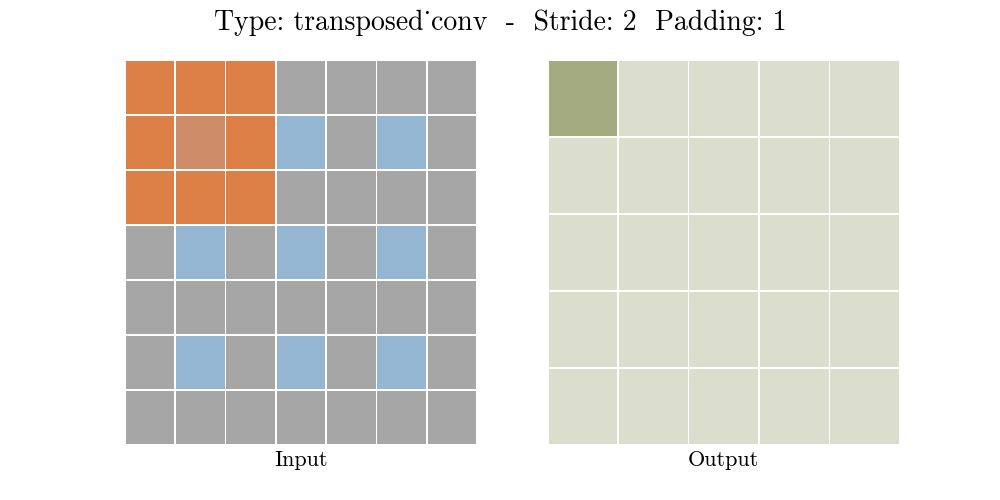

* Model Summary

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             137984    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0 

# III. 'discriminator' Model

* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image' 인지 판별
 - 이진분류

In [ ]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')

discriminator.add(Conv2D(filters = 32,
                         kernel_size = (3, 3),
                         strides = (1, 1),
                         padding = 'valid',
                         input_shape = (28, 28, 1)))
discriminator.add(LeakyReLU())
discriminator.add(MaxPool2D(pool_size = (2, 2)))
discriminator.add(Conv2D(filters = 64,
                         kernel_size = (3, 3),
                         strides = (1, 1),
                         padding = 'valid'))
discriminator.add(LeakyReLU())
discriminator.add(MaxPool2D(pool_size = (2, 2)))
discriminator.add(Conv2D(filters = 128,
                         kernel_size = (3, 3),
                         strides = (1, 1),
                         padding = 'valid'))
discriminator.add(LeakyReLU())
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))

* Model Summary

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                 

> ## 1) 'discriminator' Compile

* 학습 설정

In [ ]:
from tensorflow.keras.optimizers import Adam

discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(lr = 0.0002,
                                       beta_1 = 0.5))

# IV. 'gan' Model

> ## 1) 'generator', 'discriminator' 연결

* 'gan' 모델에서 'generator'만 학습하도록 설정
 - discriminator.trainable = False

In [ ]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

> ## 2) 'gan' Model

In [ ]:
gan = Model(gan_input, output, name = 'gan')

> ## 3) 'gan' Summary

In [ ]:
gan.summary()

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         582785    
                                                                 
 discriminator (Sequential)  (None, 1)                 93825     
                                                                 
Total params: 676,610
Trainable params: 582,273
Non-trainable params: 94,337
_________________________________________________________________


> ## 4) 'gan' Compile

* 학습 설정

In [ ]:
gan.compile(loss = 'binary_crossentropy',
            optimizer = Adam(lr = 0.0002,
                             beta_1 = 0.5))

# V. Define 'get_batches( )' Function

* MNIST image batch 생성

In [ ]:
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

# VI. 'visualize_training( )' Function

In [ ]:
def visualize_training(epoch, d_losses, g_losses):

    # 오차 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))

    # 이미지 생성 결과 시각화
    print('epoch :', epoch)
    noise = np.random.normal(0, 1, size = (24, NOISE_DIM))
    print(noise.shape)
    print('='*50)
    print(noise)
    print('='*50)
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)

    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# VII. Define Loss

In [ ]:
# loss_function = keras.losses.BinaryCrossentropy()

# train_loss = keras.metrics.BinaryCrossentropy(name = 'train_loss')
# train_accuracy = keras.metrics.BinaryAccuracy(name = 'train_accuracy')

# VIII. Model Training

* 약 35분
<br>
<br>
* .fit( )
 - 'epoch', 'batch_size' 지정
* .train_on_batch( )
 - 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용

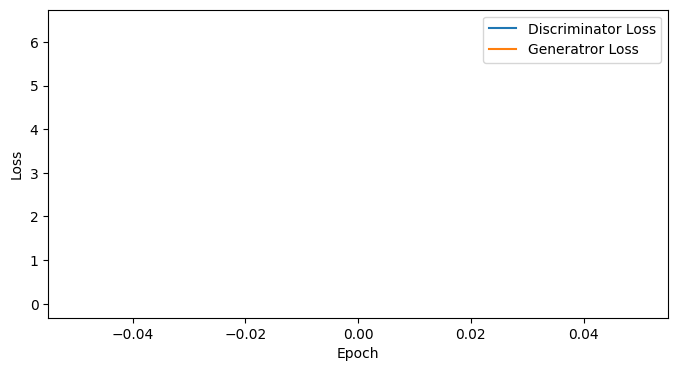

epoch: 1, Discriminator Loss: 0.0016522920923307538, Generator Loss: 6.416138648986816
epoch : 1
(24, 10)
[[ 0.81845438  1.90755686  0.24647896  0.27882771  1.32335522  0.84945558
  -0.1759415   0.75331243  0.91697397 -0.06751815]
 [ 0.23650101  1.21777684 -0.45474907  1.19508724  0.73933206  1.95655243
  -0.45403935  0.97588922  0.38568239  1.83361205]
 [-1.14758888 -0.14523545 -0.17690678 -0.87932685  2.19745462 -0.43640369
   0.31291448  0.32044797 -0.89278     1.41560604]
 [ 1.6738338  -0.62909605  0.86333506  0.39110785 -0.05529892 -0.9294472
  -1.01682714  2.07382886  0.05473343 -0.76741017]
 [ 0.45247822 -1.35568862 -1.79551581  0.04541613 -1.28100003  0.0851002
   0.36431662  0.35387621 -1.25552259 -0.0538772 ]
 [-0.50376856 -2.93802243  1.96790976 -1.62706745 -1.22990505  1.50984658
  -0.14883665 -1.10119881  0.60461359 -1.09135623]
 [-0.35911679  2.26445324  2.02202342 -0.33298863 -0.47925803  0.01684868
   1.36986232  0.96452548  0.41911682  0.60066264]
 [ 0.53573946 -0.8284

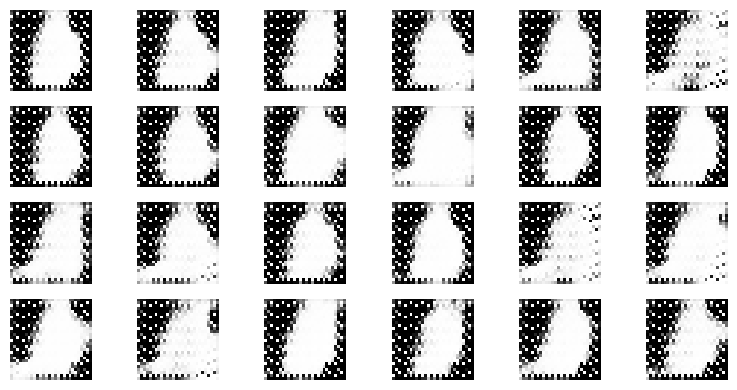

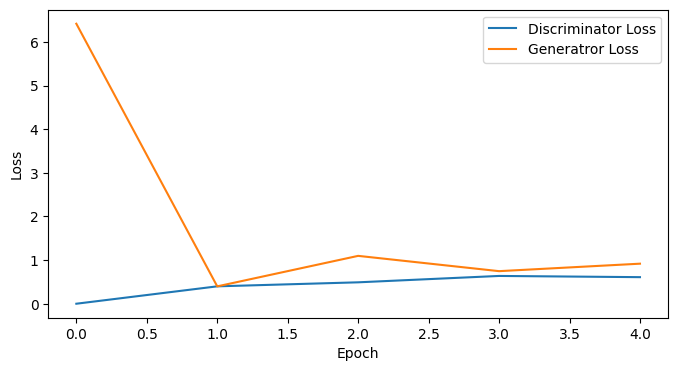

epoch: 5, Discriminator Loss: 0.4283684356370941, Generator Loss: 1.9159698724746703
epoch : 5
(24, 10)
[[ 0.93342748  1.76916612 -0.59496563 -0.47944907 -0.72646258  1.06330452
  -0.11166664  0.74734702  0.76081569 -0.47152209]
 [-0.64055005  0.4223395  -1.37161251 -0.70645488  0.21706182  0.86356768
   0.74681884  1.65521037 -0.62899145  1.56492432]
 [-0.29331342 -0.40037823  0.32222487  0.01080755 -0.75720167 -0.60959835
  -0.41251852  0.20393675 -0.17560686 -1.28258292]
 [-0.98291147 -0.09886855 -0.73224323 -2.1333663  -0.20035027 -0.39245685
   0.55531182 -0.52066879 -1.20964949  0.52187052]
 [ 1.24301205 -2.00231737  0.10432836 -0.08221149 -1.55582468 -0.5792639
  -0.41340766 -1.41160627  0.15983552  0.09641705]
 [ 0.21734061 -0.40141916 -2.03990599  0.24811777  0.78172122 -0.61254091
  -0.76476751  0.23778193  0.83248495  1.04412622]
 [-0.03040108  0.13076879 -1.89674516 -1.12336679 -0.53061578 -1.17157069
   0.23678584 -0.10817393  0.815865   -0.58152535]
 [ 0.24882451  0.18392

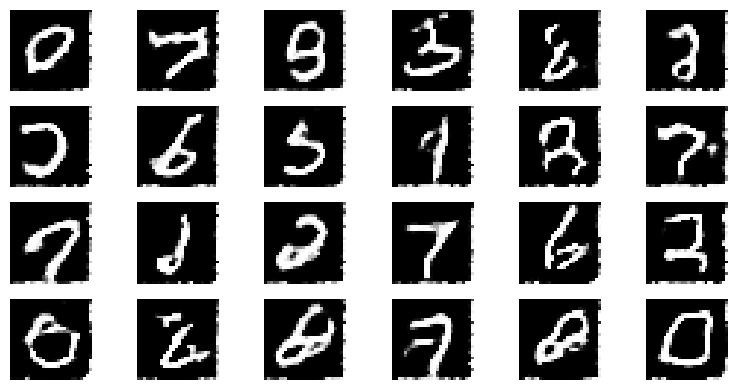

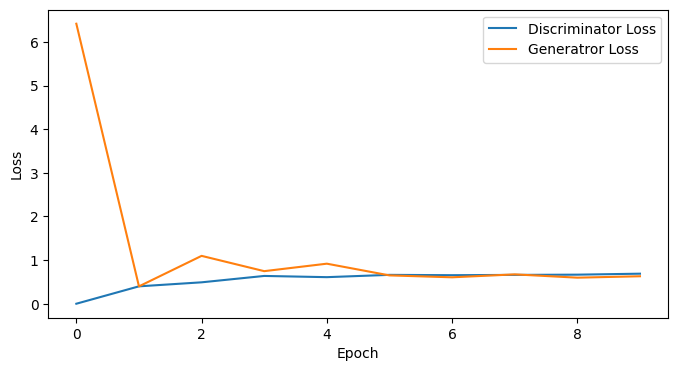

epoch: 10, Discriminator Loss: 0.5479021362145431, Generator Loss: 1.2740736246109008
epoch : 10
(24, 10)
[[ 0.06001019  0.40002047 -1.68588872  1.67854265 -0.32205102  0.26051895
  -0.75809077  1.20787074 -0.892516    1.83811258]
 [-0.53830709 -0.16984787  0.0519205  -1.28666889 -0.27910464 -0.5574195
  -0.97219406 -0.18020972 -0.65767554  0.11503565]
 [-0.23985586 -1.09289622 -0.36254777  0.33343865  1.4635359   0.18832184
   2.45722588  0.90488685  0.86581416 -0.93314318]
 [ 0.12329783 -0.72090401  0.48950583 -0.84681888  1.90638007  0.23892507
  -1.53179163 -1.16475149  1.09792082 -0.10871368]
 [ 0.27185823 -0.03608388 -0.20958896  0.63776722 -0.30731144  0.09532602
  -2.19655287 -1.04786752 -0.82469828  0.4511659 ]
 [ 1.45517963  0.31956029  0.64163188  0.58850769  0.18608437  0.01649585
   0.28017541 -0.29450676 -0.00633207  0.02978478]
 [ 0.32270494 -0.0251802   1.41176225 -1.25469496  0.10699366  0.47166891
  -0.81168827 -1.56944156 -0.15445519 -1.34743782]
 [ 1.77893566 -0.073

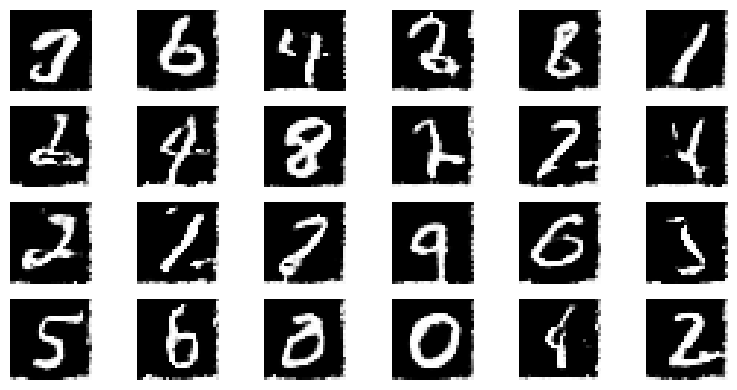

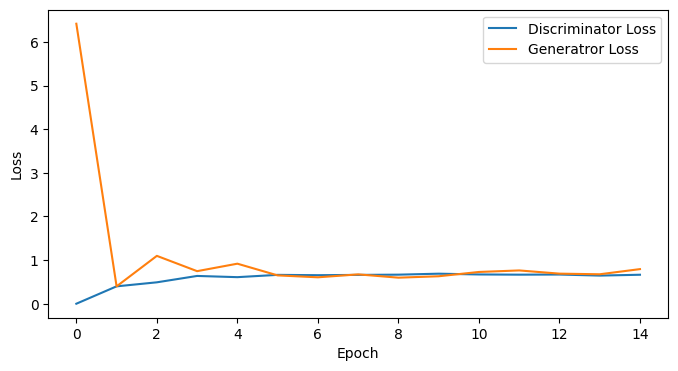

epoch: 15, Discriminator Loss: 0.5866731081856414, Generator Loss: 1.0930372675259907
epoch : 15
(24, 10)
[[ 0.90629087 -0.58196317 -0.15115418  0.30263852  0.31659611 -0.11301815
   1.04279965 -0.96296265  0.11964947  1.1741412 ]
 [-0.59915703 -0.19482223  0.58580331  0.50079924 -0.71851475 -0.48615025
  -0.21193013 -1.27047031 -0.95763351  1.52332466]
 [ 1.07325637  0.32724979  0.45696931 -0.38908149  0.72185174  0.8842012
  -1.15189748  0.53333634  1.93645644  1.02714309]
 [-0.97338076 -1.33148411 -0.89486329  0.31763715 -1.32532285  0.21453995
  -1.10729758 -0.18291386  2.24237004  1.62877136]
 [-0.48719351  2.07430407  0.76122932  1.51426386 -1.26120307  2.06243223
   1.66869322  0.10902787 -0.12704307 -1.77327206]
 [ 0.61244911  1.9505316  -0.92651522 -0.03605795 -0.35302434  0.62839013
   0.59364589  1.68413251  0.47004011  0.6219966 ]
 [-1.34946801  0.97200209  1.20166175 -0.47676801  1.01148036  1.47572504
   0.7160245   0.22671027  0.88278148  0.38010352]
 [ 2.17294491 -0.028

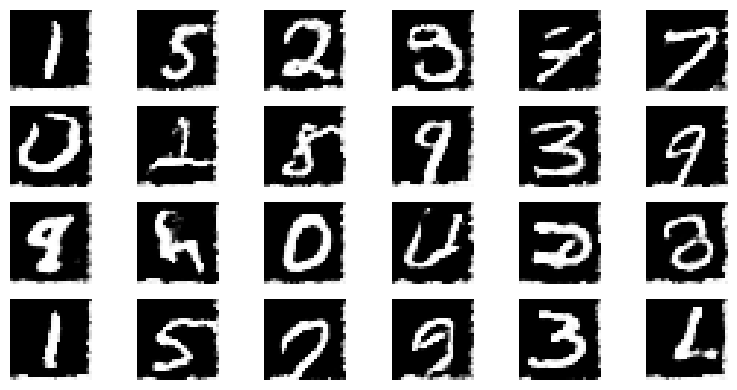

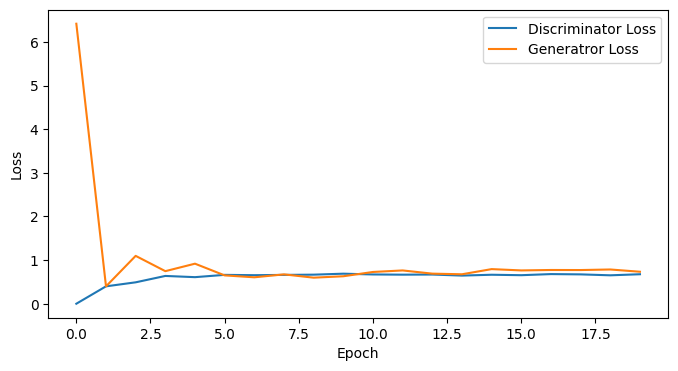

epoch: 20, Discriminator Loss: 0.6069640334288124, Generator Loss: 1.0113929271698
epoch : 20
(24, 10)
[[ 9.41046991e-01  1.00604982e+00  5.79789344e-02  3.17012860e-01
   1.11361271e+00  1.88570499e+00  2.00768259e+00  5.02120490e-01
   1.35583288e+00  8.73173452e-01]
 [ 7.02956185e-01  4.06520164e-01 -6.71037363e-01  1.29381009e+00
   1.87123724e+00  2.87151761e-01 -5.09230822e-02  2.18030985e+00
   1.05534908e+00 -1.65130348e+00]
 [-1.38500782e+00  1.52595059e+00  8.14012194e-01  5.18404628e-01
   1.93504539e-01 -9.44762315e-01  5.99260766e-01  5.14992724e-01
  -4.38199916e-01 -1.31115897e+00]
 [-2.75433774e-02 -1.20894027e+00  6.38782100e-01  2.28104067e-02
  -2.64987646e-01 -9.68810773e-01  9.58716985e-01  8.48887541e-01
  -1.03938067e+00  2.31597956e-02]
 [ 9.91427314e-01  9.90164522e-01  1.98850910e-01 -1.26542450e+00
   3.17973518e-01 -2.67534464e+00 -1.04454840e+00 -1.07673072e-01
  -1.75783222e+00 -5.94896837e-01]
 [-6.67480811e-01 -1.33525160e+00  8.04250342e-01  1.64182889e

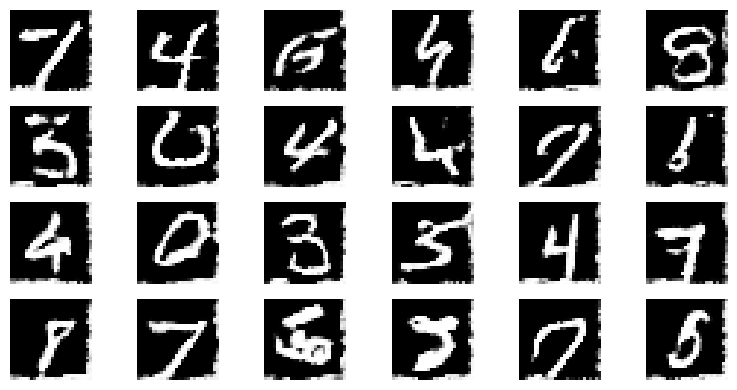

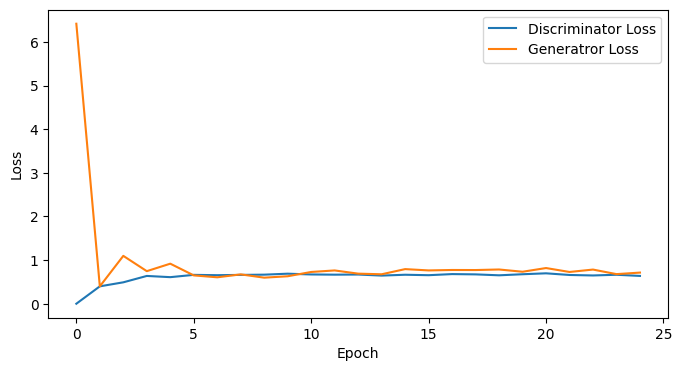

epoch: 25, Discriminator Loss: 0.618015746739693, Generator Loss: 0.9581818628311157
epoch : 25
(24, 10)
[[ 5.35107791e-01 -1.06790811e+00  3.25869054e-01  1.02693639e+00
  -8.82523587e-01  1.29392313e+00 -2.99820658e-01  1.17536918e-01
   1.30668075e-01 -4.44978039e-01]
 [ 2.18544943e-02  1.36418917e+00 -6.61003708e-01  1.27000379e+00
  -5.31608180e-01 -1.71864850e+00  8.20604097e-02 -8.03622873e-01
  -2.78799825e-03 -2.53045962e-01]
 [ 1.90922955e-01 -1.29090694e+00  9.94250995e-01 -6.31689058e-01
   1.31635019e+00  6.64537613e-01  1.51593955e+00  1.75241728e+00
   9.71935314e-02 -5.15682301e-01]
 [ 2.59021367e-01 -1.41867771e+00  1.29364546e+00 -1.09250798e+00
   1.83842934e+00  2.70078117e-01 -1.95163119e+00 -1.21160744e+00
  -1.89820251e-01 -9.17008172e-01]
 [ 1.63592941e+00 -2.14472784e-02  1.48446779e-01 -1.03693139e-01
   1.51026188e+00  1.02748025e+00  3.24294462e-01 -1.16249222e+00
   7.91684992e-01 -1.17639044e+00]
 [ 8.08154181e-01 -2.51674131e-01 -1.10110546e+00  6.8825967

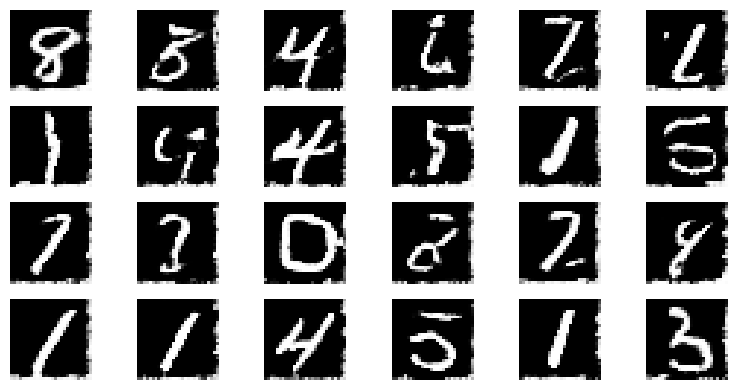

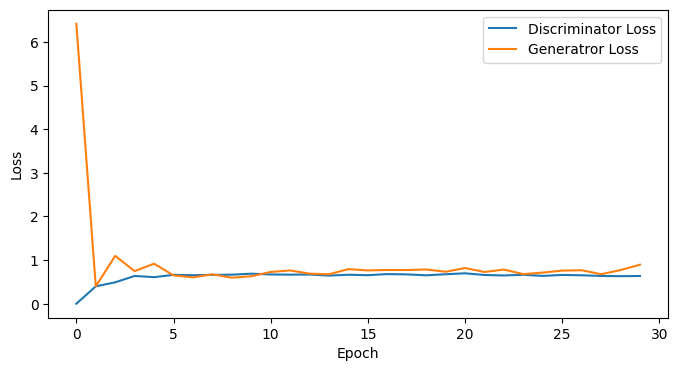

epoch: 30, Discriminator Loss: 0.6223838187482519, Generator Loss: 0.927668176094691
epoch : 30
(24, 10)
[[ 2.54456615e+00  6.22653520e-01 -5.39291510e-01  2.05523265e+00
  -2.89346213e-01 -1.76446320e-03 -7.99116051e-02 -1.26144564e+00
   1.50497005e-01  2.13533621e-01]
 [ 5.05557848e-01 -1.20722384e+00 -2.82738005e-01  8.63773735e-01
   1.34552575e+00  5.80355826e-01 -1.01807202e-02  3.53501123e-01
   1.19277004e+00  1.21783117e+00]
 [ 3.69781728e-01 -1.06546056e+00 -4.30830930e-01  3.76158662e-01
   7.38722057e-02  8.22119031e-01 -9.25521603e-01 -1.01283918e-01
  -3.94799697e-01  1.27076080e+00]
 [ 1.29755082e+00 -1.44844679e+00  1.17367234e+00 -2.16974642e+00
  -1.49528661e+00 -9.27326656e-02  3.82794359e-02  5.89156856e-01
   8.22894589e-01 -6.23248071e-01]
 [ 2.34936741e+00  1.17897701e+00 -1.98742430e-01 -9.84008011e-02
   1.75938114e+00 -4.27740674e-01  3.84816602e-01 -1.61843533e-01
   6.07444387e-01  2.46950376e-02]
 [ 7.66265191e-01 -1.56122910e+00 -4.70484949e-01  1.2323089

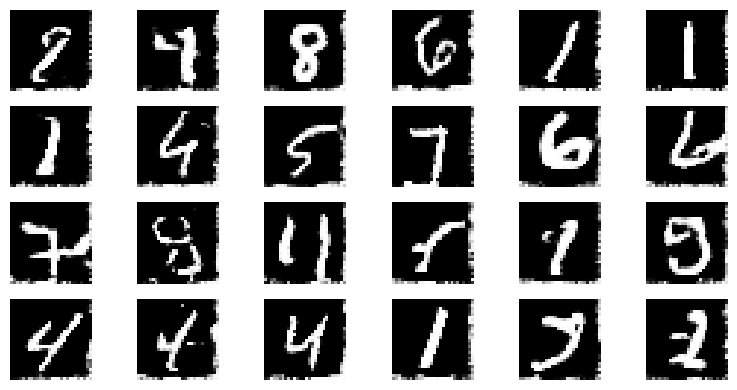

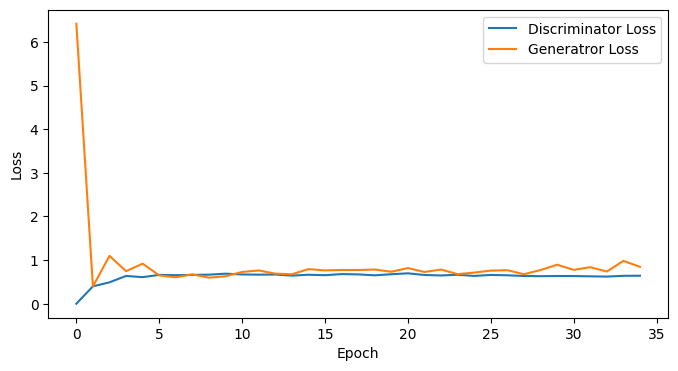

epoch: 35, Discriminator Loss: 0.6241205519630707, Generator Loss: 0.9147246173449926
epoch : 35
(24, 10)
[[ 3.61938917e-01  1.35064489e-01  1.64981981e-01  5.40937267e-01
   5.71980657e-01 -5.18728098e-01  6.35704506e-01 -5.12554781e-01
   1.84875760e-01  4.64554461e-01]
 [ 5.53301804e-01  3.03667074e-01 -1.48795839e+00 -5.08864931e-01
   5.92954681e-02 -1.47861006e-01  3.23956948e+00 -1.13282893e+00
   8.67333328e-01 -3.09253240e-01]
 [-3.27631478e-01 -9.73763357e-02 -2.16982574e+00  2.02312484e+00
   6.44011140e-01  1.33264460e+00 -5.27755037e-01  5.03976271e-01
  -1.11414048e+00 -1.83720872e-01]
 [-1.28085547e+00 -6.63536417e-01  8.79071488e-01 -1.77337189e+00
  -1.29731332e+00  1.15192050e+00  2.06194761e-01 -3.80878238e-01
   2.36539705e-02 -9.13874047e-01]
 [-2.06397722e-01 -1.50347856e+00 -5.78945683e-01  6.37064315e-02
  -3.46137929e-01  1.21201465e+00 -7.42132210e-02  1.52222858e-01
  -1.14844374e+00  1.01290518e+00]
 [ 1.26022754e+00 -7.74766662e-01  2.41962475e+00 -5.800436

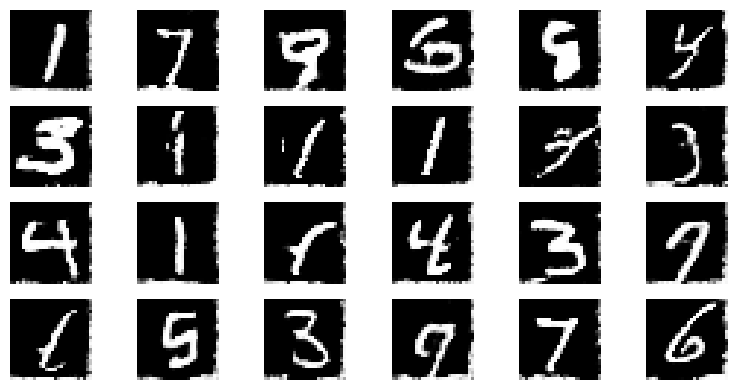

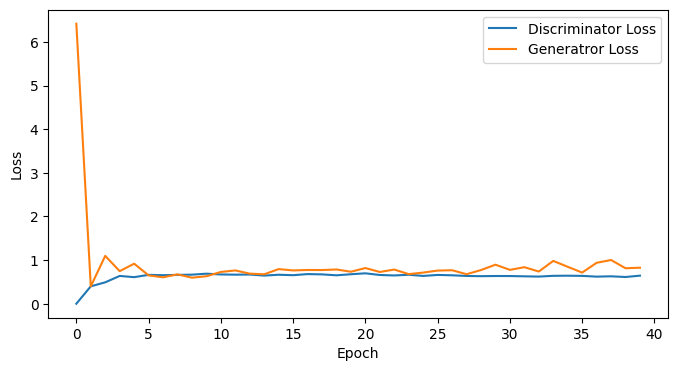

epoch: 40, Discriminator Loss: 0.6248530132492306, Generator Loss: 0.9078619688749313
epoch : 40
(24, 10)
[[ 0.70452129 -0.14508076  0.57071138 -1.59922489 -0.36205852  0.8621333
   0.52415365 -0.25674041  0.24172515 -0.55211758]
 [ 0.30158546  0.16440372  1.57643079 -0.55714147 -0.83771549 -1.67845015
   0.42681206 -1.68893331 -1.52786157  0.21184535]
 [-1.58778675 -0.06917459 -1.50354515  0.61678581  1.29788869  1.06832543
   1.63874889 -0.77755959 -0.03555023  0.09168759]
 [-1.54494096 -0.03255268 -0.12133647  0.24441257 -0.09388361 -0.24775451
   1.9528576  -0.54388839 -0.15671498 -0.35849184]
 [ 0.26528723 -0.83153007  0.36547385  0.80132994  0.67364338  1.25343648
   0.59657621  0.42230708 -0.15846569 -1.47960339]
 [ 0.64842434  0.02268261 -0.08004136 -0.02736141  0.43699336 -0.17174808
  -0.97629794  0.81283282  0.058817    0.46929351]
 [ 0.78881859  0.05290578 -0.33514821 -1.09051255 -0.50116267 -0.68297446
   0.32702612 -0.02791687  0.16579285 -1.37411373]
 [-1.16726178 -0.894

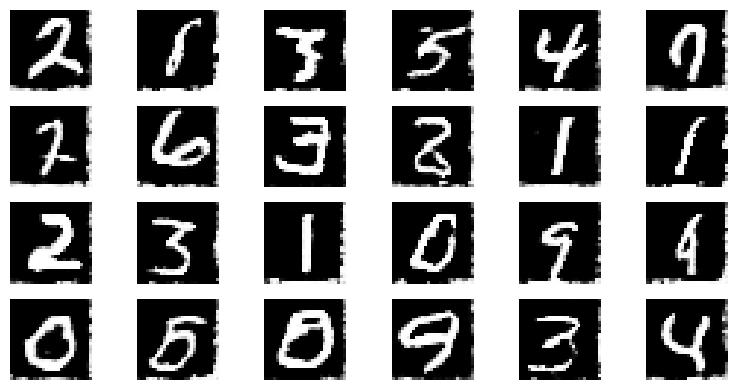

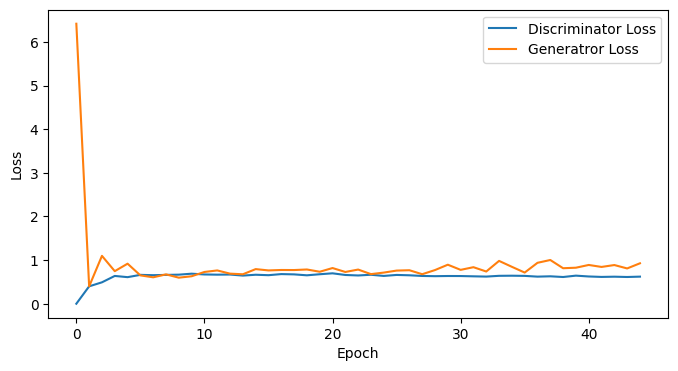

epoch: 45, Discriminator Loss: 0.6242795849658755, Generator Loss: 0.9038673745261299
epoch : 45
(24, 10)
[[ 0.05733155  0.57484343 -0.19940765 -0.12072741  0.20090961 -0.52654192
  -0.45433199 -1.47643888  1.14813114  0.08691523]
 [ 0.1247864  -2.23023152 -2.44256285 -1.26043359 -2.83045556 -1.03831626
  -1.40867293 -0.88790555 -0.83379423  1.8967378 ]
 [ 0.48926036 -1.52658931 -0.75275602 -0.25266657  0.78025196 -0.11509671
   0.21897211 -0.21788647  0.71793337  1.86249235]
 [ 1.51518687  0.72330256  0.24133709  0.62083322  1.51375191  0.01393783
  -0.60780899  1.37447709  0.82602412 -0.95582993]
 [ 0.01741708 -0.53811259 -1.77299674  1.22341759  0.29775543 -0.35348843
  -0.47656037 -2.00143644  0.10842144 -0.94255384]
 [-0.01402523 -1.35688116 -0.79048955  0.08490189  0.70266345  0.10072807
  -0.67736436 -0.7828384  -1.51153992 -0.30144066]
 [-0.02345174 -1.69119939  1.35716882  2.40586006  1.50509609 -0.53864333
   0.72995003 -0.56664129 -0.27343682  0.12037083]
 [ 0.60718365  0.05

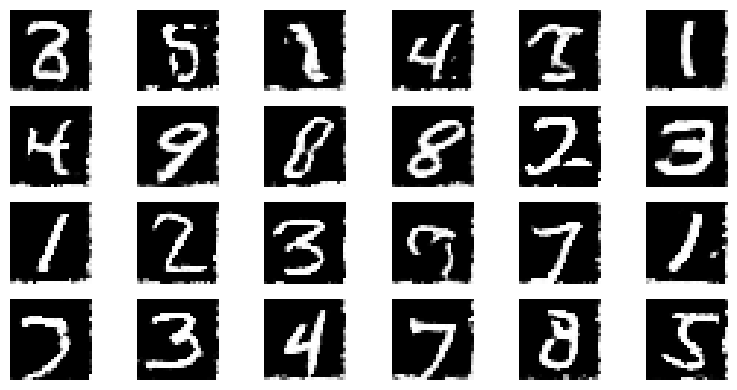

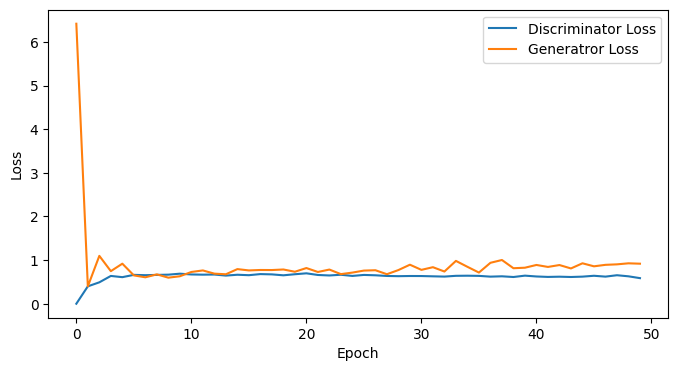

epoch: 50, Discriminator Loss: 0.6245691226259805, Generator Loss: 0.9034923732280731
epoch : 50
(24, 10)
[[-2.88750603e-01  1.28189754e+00  1.33223806e+00 -2.88372278e-01
   2.57426440e-02  8.16856726e-01  1.87379547e+00  2.82311960e-01
  -5.27828217e-01 -1.04796202e+00]
 [-2.44005718e+00 -4.18033030e-01  5.11464388e-01  1.14316595e+00
   3.41600206e-01 -1.71606657e+00 -5.34089060e-02 -8.23097597e-01
  -1.20284132e+00 -1.09274707e+00]
 [-2.05889630e-01  6.48357031e-01 -1.13949962e+00  2.30217700e+00
  -1.07106477e+00 -1.63744146e-01  4.71000991e-01  1.06859258e+00
  -6.50531398e-01 -2.56307123e-01]
 [ 1.18878888e+00  4.30536071e-01 -4.74675070e-01 -7.72933172e-01
  -7.38968094e-01  9.20241264e-02 -8.68145581e-01 -2.72879004e+00
   6.30939690e-01  7.37097294e-01]
 [-9.71476948e-01  1.66902852e+00  4.08712136e-01 -4.20476132e-02
   2.05056232e-01 -9.76831904e-01  2.49414475e-01  9.88517807e-01
   3.58634242e+00 -1.82640993e+00]
 [-5.50499590e-01  1.04316000e+00 -4.12023503e-02  9.628998

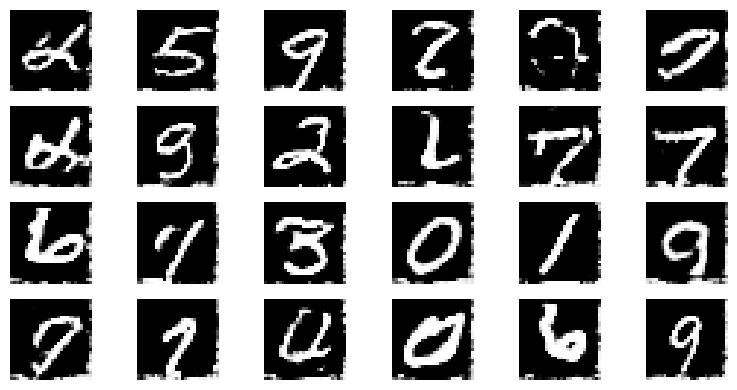

CPU times: total: 4min 10s
Wall time: 24min 8s


In [ ]:
# %%time

EPOCHS = 50
BATCH_SIZE = 128

# 'discriminator', 'gan' Loss 저장 List
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # batch 별 학습
    for real_images in get_batches(X_train, BATCH_SIZE):
        # Random Noise 생성
        input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])

        # Fake Image 데이터 생성
        generated_images = generator.predict(input_noise, verbose = 0)

        # 'gan' 학습용 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])

        # 'gan' 학습용 y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 1

        # 'discriminator' 학습
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)

        # 'gan' 학습
        noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)

        # 'discriminator' 학습 정지
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # 생성 결과 시각화
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

# The End